In [1]:
import anndata as ad
import matplotlib.pyplot as plt
import muon as mu
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib as mpl
from collections import Counter
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter, PercentFormatter
# mpl.rcParams['font.family'] = 'Arial'
figPath = "NKTCL-figure-2.18"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["font.size"] = 14

In [3]:
adata = sc.read_h5ad("/data/hanxue/hanxue_data/adata-xwt-annotated.h5ad")

In [5]:
adata.obs['major_type'].unique()

['Epithelial', 'T cells', 'Myeloid', 'PeriVascular', 'Fibroblast', 'B cells', 'Endothelial', 'Plasmablast', 'Mast']
Categories (9, object): ['B cells', 'Endothelial', 'Epithelial', 'Fibroblast', ..., 'Myeloid', 'PeriVascular', 'Plasmablast', 'T cells']

In [4]:
adata_B = adata[adata.obs['major_type'] == 'B cells', :]

In [5]:
def MergeSubAdata(adata, subAdata, obsName, subObsName):
    obs = pd.Series(list(adata.obs[obsName].copy()), index=adata.obs_names)
    subObs = pd.Series(list(subAdata.obs[subObsName].copy()), index=subAdata.obs_names)
    obs.loc[subObs.index] = subObs
    return pd.DataFrame(obs, columns=[obsName])

def marker(adata, groupby, method='wilcoxon', prefix=''):
    sc.tl.rank_genes_groups(adata, groupby = groupby, method = method)
    sc.tl.dendrogram(adata, groupby=groupby, use_rep='X_pca_harmony')
    sc.pl.rank_genes_groups_dotplot(adata, groupby = groupby, save=prefix+groupby+'.svg')
    return adata

def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=True, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

In [6]:
def propPlot(age_df, barlabels1, barlabels2, ax, colors=sc.pl.palettes.default_20, xlabel='Sample ID', show_y=True, xrotate=90):
    all_df = age_df.sum(axis=1)
    age_normdf = pd.DataFrame([age_df.loc[i,:]/all_df[i] for i in barlabels1], index=barlabels1)
    age_cumdf = pd.DataFrame([np.cumsum(age_normdf.loc[i,:]) for i in barlabels1], index=barlabels1)
    norm_gdfs = age_normdf
    cum_gdfs = age_cumdf
    for i, col in enumerate(age_df.columns):
        height = norm_gdfs[col]
        starts = cum_gdfs[col] - height
        rects = ax.bar(barlabels2, height, bottom=starts, width=0.9, color=colors[i], edgecolor='white', linewidth=0.5,
                        label=col, alpha=1)
    
        # ax.bar_label(rects,age_df.loc[:, col], label_type='center', color='lightgrey', fontsize=14)
    ax.legend( bbox_to_anchor=(1, -0.3), 
              handletextpad=0.5, frameon=False,
                          borderpad=0.4,
                          columnspacing=1,
                          handlelength=0.65,
              loc='lower left', fontsize=14)
    if show_y:
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
        ax.set_ylabel('Cell proportions')
    else:
        ax.yaxis.set_visible(False)
        ax.spines.left.set_visible(False)
    ax.set_xlabel(xlabel)
    ax.set_xticks(barlabels2)
    ax.set_xticklabels(labels=barlabels2,rotation=xrotate,fontsize=13)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
 # 关闭背景网格线
    ax.grid(False)  

In [7]:
def anno(adata:ad.AnnData, annoDict:dict, default="Unknown"):
  adata.obs['cnv_status'] = default
  for key in annoDict.keys():
    adata.obs.loc[adata.obs['cnv_leiden'].isin(annoDict[key]), 'cnv_status'] = key
  return adata

2025-09-28 08:11:13,828 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Ignoring processing doublet cells...


2025-09-28 08:11:15,073 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-28 08:11:15,095 - harmonypy - INFO - Iteration 1 of 20
2025-09-28 08:11:15,876 - harmonypy - INFO - Iteration 2 of 20
2025-09-28 08:11:16,301 - harmonypy - INFO - Iteration 3 of 20
2025-09-28 08:11:16,683 - harmonypy - INFO - Converged after 3 iterations
/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/scanpy/external/pp/_harmony_integrate.py:101: ImplicitModificationWarning: Setting element `.obsm['X_pca_harmony']` of view, initializing view as actual.
  adata.obsm[adjusted_basis] = harmony_out.Z_corr.T
/home/hanxue/miniconda3/envs/omicverse/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/tmp/ipykernel_807612/3054425537.py:31: FutureWarning: In t

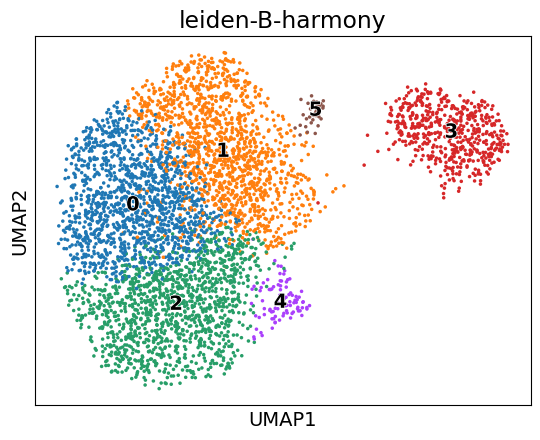

In [8]:
adata_B = clu(adata_B, 'leiden-B-harmony', resolution=0.5)

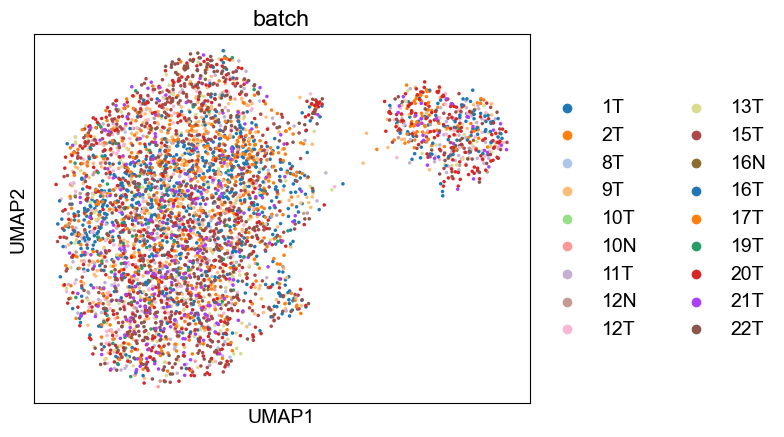

In [12]:
sc.pl.umap(adata_B, color='batch')

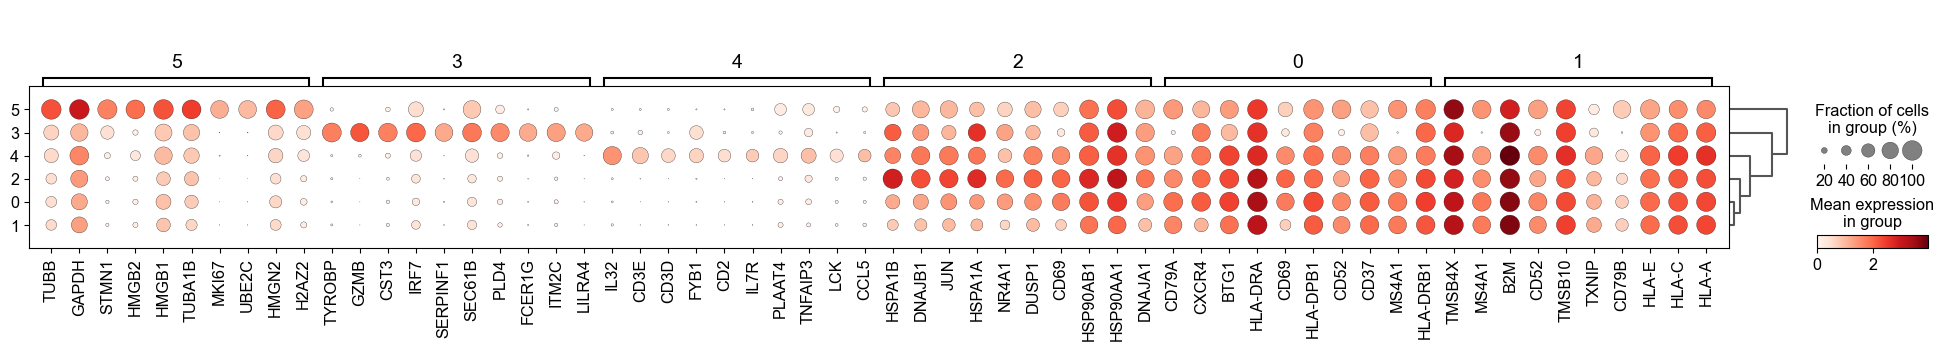

In [10]:
adata_B = marker(adata_B, 'leiden-B-harmony')

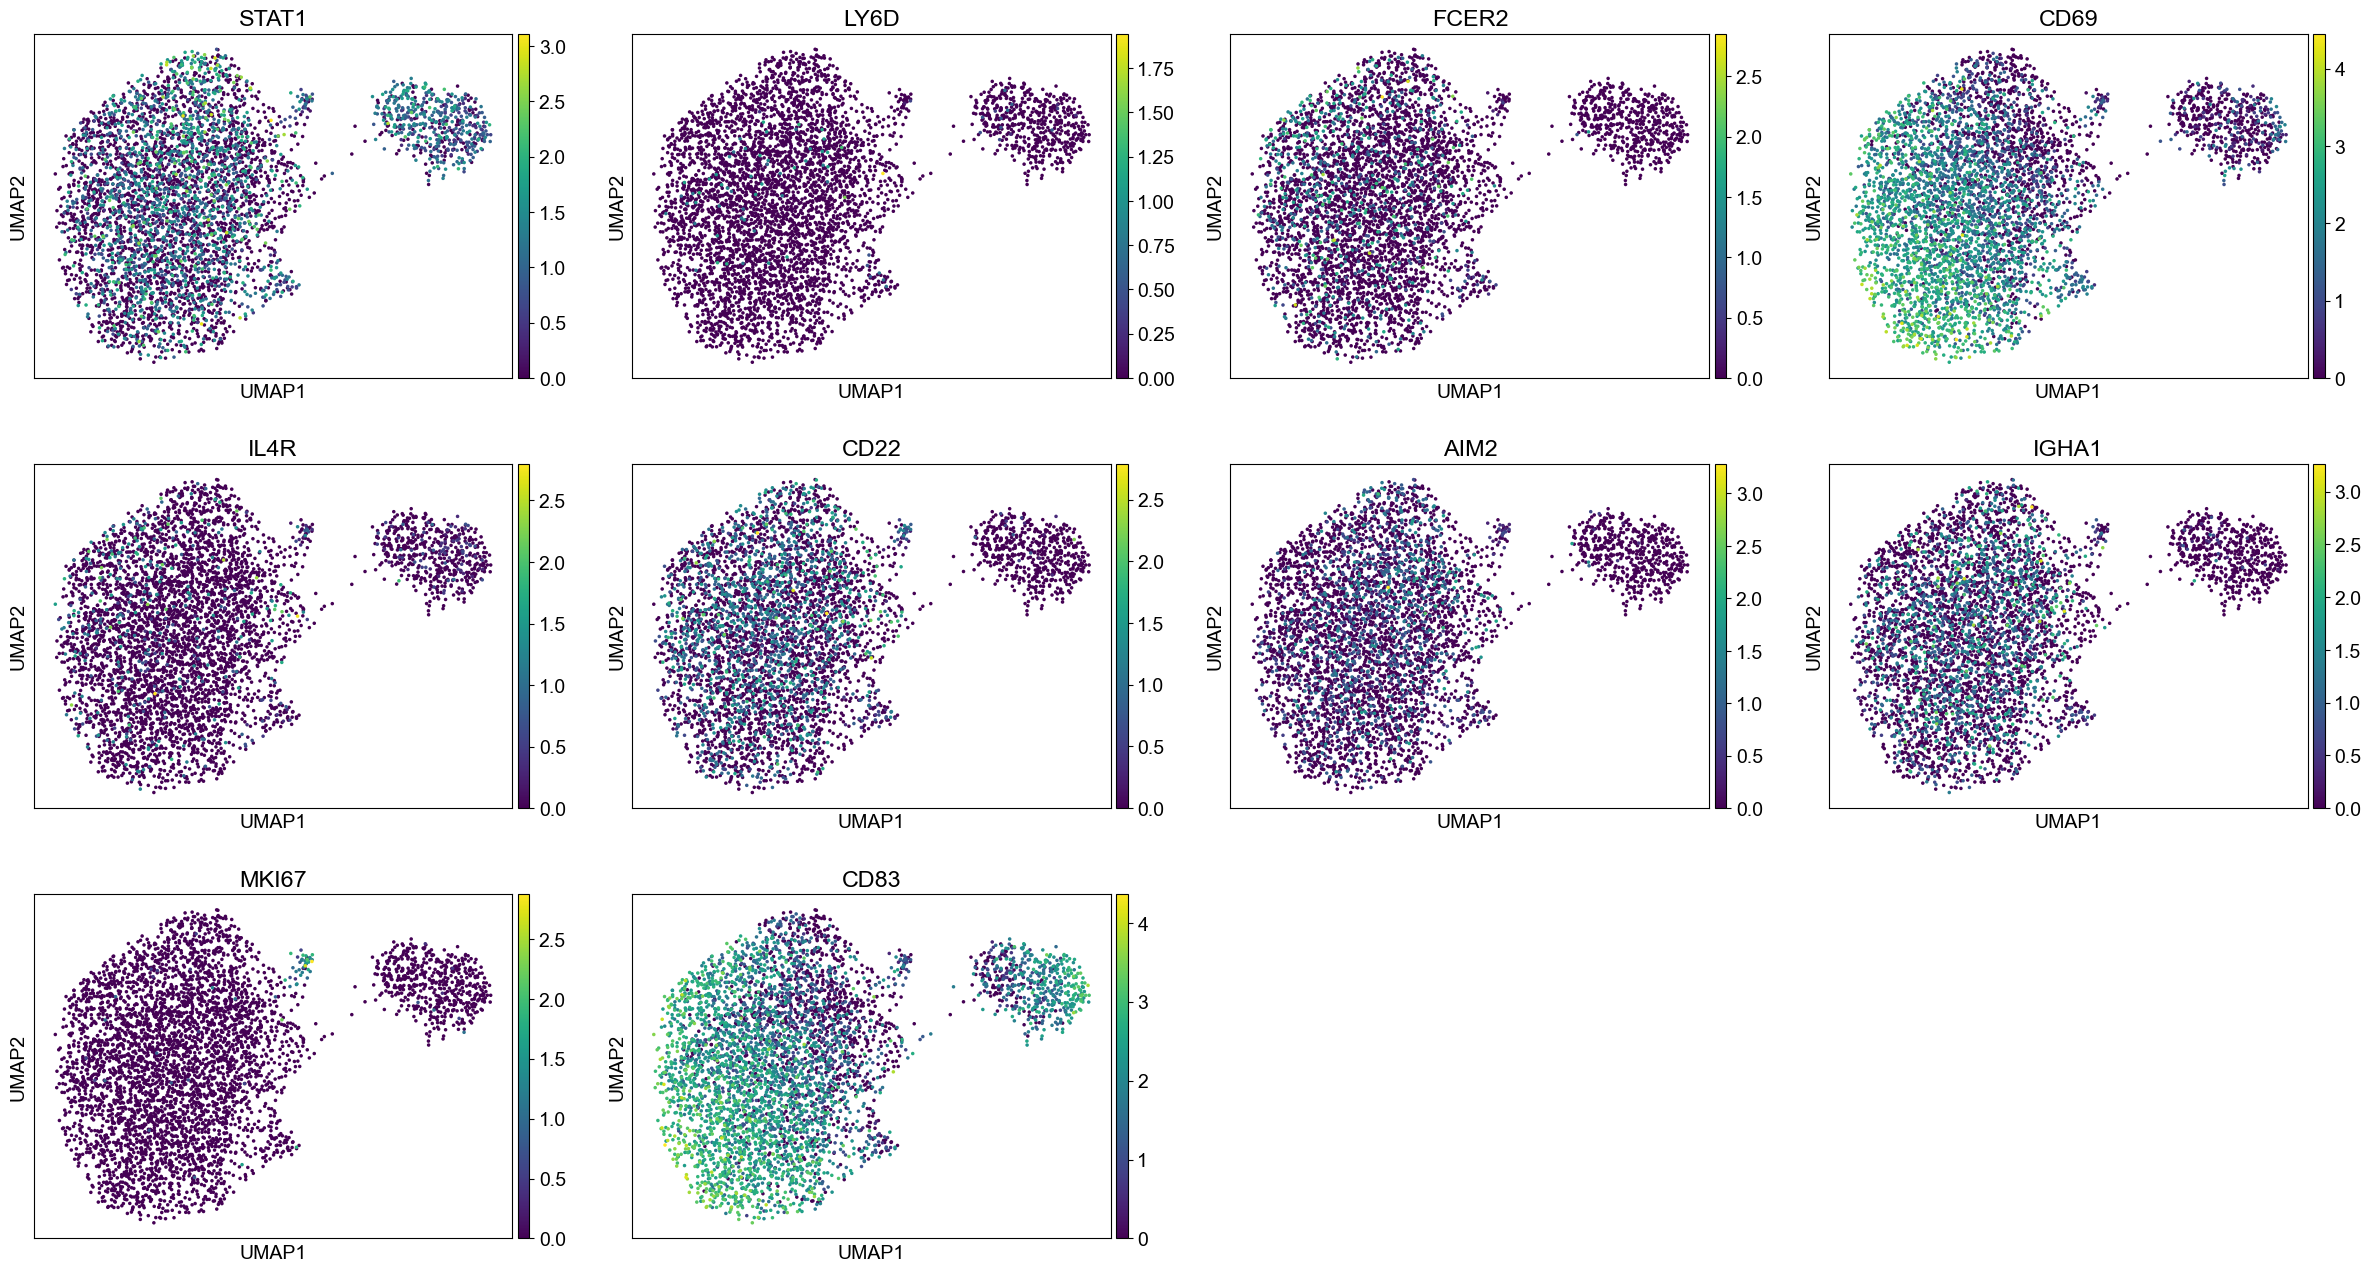

In [13]:
sc.pl.umap(adata_B, color=['STAT1','LY6D', 'FCER2', 'CD69', 'IL4R', 'CD22', 'AIM2', 'IGHA1', 'MKI67', 'CD83'], 
           legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")

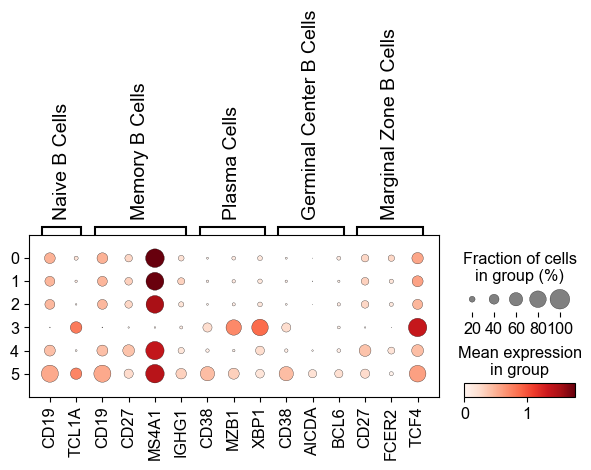

In [ ]:
b_cell_markers = {
    'Naive B Cells': ['CD19',  'TCL1A'], # 初始B细胞
    'Memory B Cells': ['CD19', 'CD27', 'MS4A1', 'IGHG1'], # 记忆B细胞
    'Plasma Cells': ['CD38',  'MZB1', 'XBP1'], # 浆细胞
    'Germinal Center B Cells': [ 'CD38', 'AICDA', 'BCL6'], # 生发中心B细胞
    'Marginal Zone B Cells': ['CD27',  'FCER2', 'TCF4'] # 边缘区B细胞
}

# 2. 可视化标志物表达
sc.pl.dotplot(adata_B, b_cell_markers, groupby='leiden-B-harmony') 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

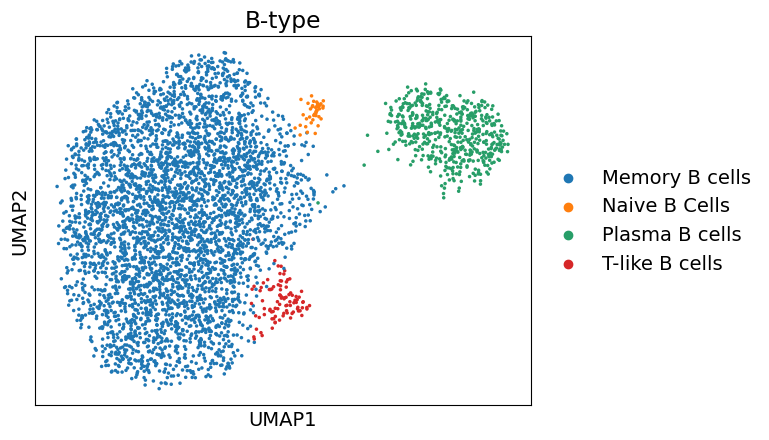

In [9]:
adata_B.obs['B-type'] = 'B unassigned'
adata_B.obs.loc[
    adata_B.obs["leiden-B-harmony"].isin(["5"]), "B-type"
] = "Naive B Cells"
adata_B.obs.loc[
    adata_B.obs["leiden-B-harmony"].isin(["4"]), "B-type"
] = "T-like B cells"

adata_B.obs.loc[
    adata_B.obs["leiden-B-harmony"].isin(["3"]), "B-type"
] = "Plasma B cells"

adata_B.obs.loc[
    adata_B.obs["leiden-B-harmony"].isin(["0", '1', '2']), "B-type"
] = "Memory B cells"
sc.pl.umap(adata_B, color="B-type", legend_fontoutline=True, palette=sc.pl.palettes.default_20, save="-B-anno.svg")

In [19]:
sc.write("adata-B.h5ad", adata_B)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

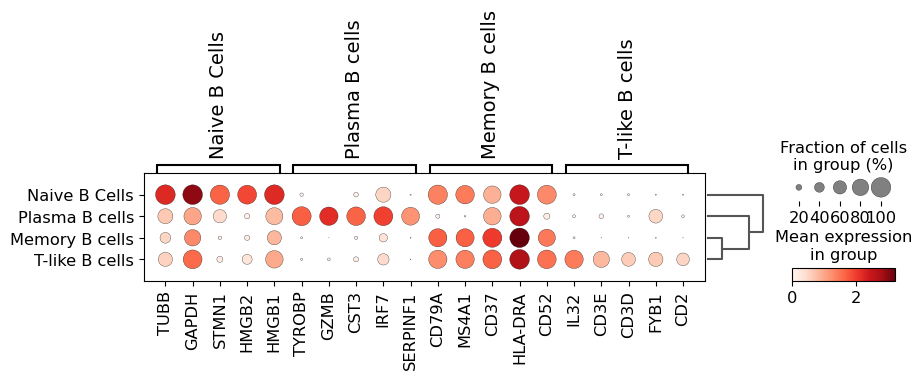

In [12]:
sc.tl.rank_genes_groups(adata_B, groupby='B-type', method='wilcoxon')
sc.tl.dendrogram(adata_B, groupby='B-type')
sc.pl.rank_genes_groups_dotplot(adata_B, groupby='B-type', n_genes=5, save='-B.svg')